In [21]:
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import seaborn as sns
import sys
from utils import *

In [22]:
nt = 'compute_haswell'
slot = 24  # length of the interval in hours for resampling
rw = 7

outlier_threshold = 20
outlier_confidence = 0.90
test_size = 0.3
time_range = (pd.Timestamp(2018, 1, 1), pd.Timestamp(2021, 7, 1))

In [23]:
hisotry = select_data('compute_haswell.csv', time_range)
plot_rsrc(hisotry, 'compute_haswell')

In [24]:
# hisotry = cusum_detector(hisotry, outlier_threshold, test_size=test_size)  # node_data is the last 20% of the history data
# plot_rsrc(hisotry, 'compute_haswell', confidence=outlier_confidence, show_outlier=True)
# hisotry = hisotry[hisotry['outlier'] <= outlier_confidence]

## Step 1. Resample by a time slot

Counting the number of nodes assigned to Chameleon users within a fixed time interval.

In [25]:
node_data = resample_sum(hisotry, slot)
node_data.dropna(inplace=True)
plot_rsrc(node_data, nt)

In [26]:
node_data.set_index(['start_on'], inplace=True)

In [27]:
actual_train, actual_test = train_test_split(node_data, test_size=test_size, shuffle=False)

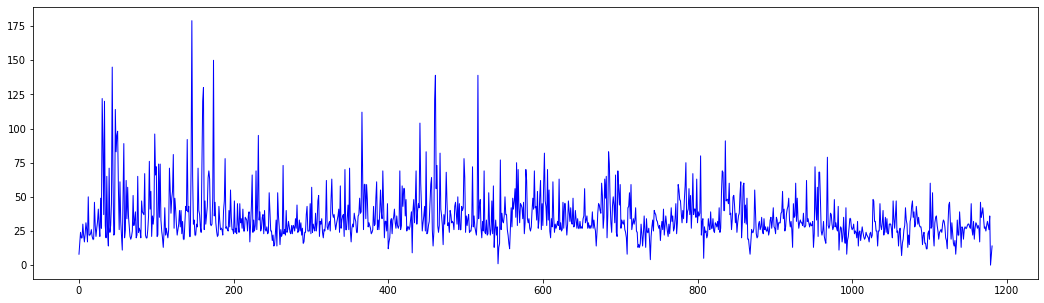

In [28]:
from tsmoothie.smoother import DecomposeSmoother, LowessSmoother

s_dataset = node_data.values

# operate smoothing
# smoother = DecomposeSmoother(smooth_type='lowess', periods=1, smooth_fraction=0.3)

"""
LowessSmoother uses LOWESS (locally-weighted scatterplot smoothing)
to smooth the timeseries. This smoothing technique is a non-parametric
regression method that essentially fit a unique linear regression
for every data point by including nearby data points to estimate
the slope and intercept. The presented method is robust because it
performs residual-based reweightings simply specifing the number of
iterations to operate.
"""
days = node_data.index[-1] - node_data.index[0]
frac = 1/days.days  # fraction of one day
smoother = LowessSmoother(smooth_fraction=frac, iterations=1)
smoother.smooth(s_dataset)

# generate intervals
low, up = smoother.get_intervals('sigma_interval')

# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

plt.plot(smoother.smooth_data.squeeze(), linewidth=1, color='blue')
plt.fill_between(range(len(smoother.data.squeeze())), low[0], up[0], alpha=0.3)
plt.show()

In [29]:
node_data['node_cnt'] = smoother.smooth_data.squeeze()

## Step 2. Stationarity(ADF) Test
### Compute the firt order difference if timeseries is non-stationary

In [30]:
results = test_stationarity(node_data.node_cnt)

                                   value
Test Statistic Value             -5.7327
p-value                      6.54428e-07
Lags Used                             15
Number of Observations Used         1166
Critical Value(1%)              -3.43597
Critical Value(5%)              -2.86402
Critical Value(10%)             -2.56809


In [31]:
do_fod = False
if results['value']['Test Statistic Value'] > results['value']['Critical Value(1%)']:
    node_data_diff = node_data.shift(1)
    node_data.node_cnt = node_data.node_cnt - node_data_diff.node_cnt
    node_data = node_data.dropna()
    plot_rsrc(node_data, nt)
    do_fod = True

In [32]:
if do_fod:
    test_stationarity(node_data.node_cnt)

## Step 3. Seasonality Test

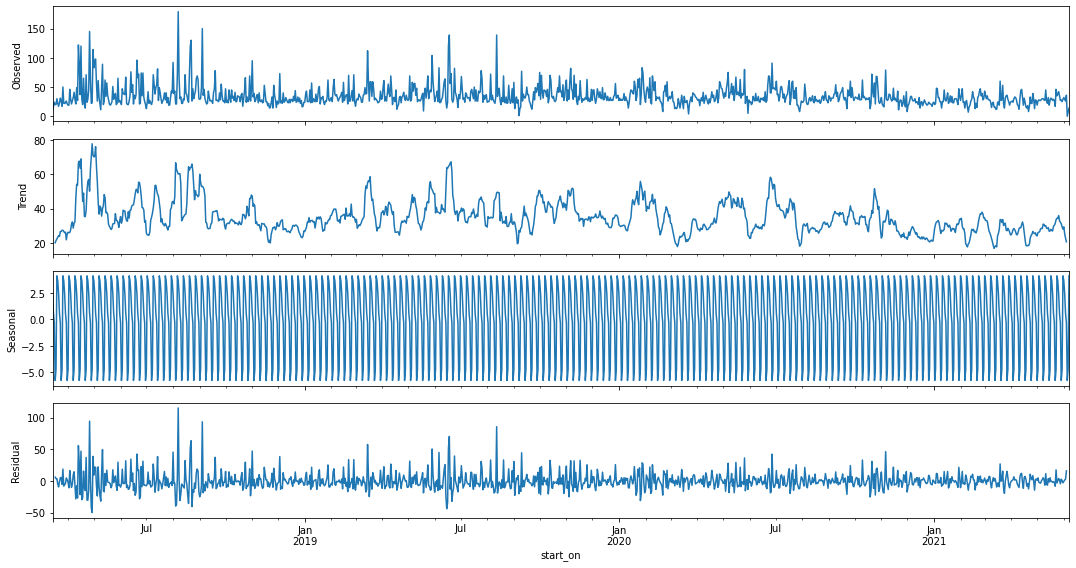

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,8))
tmp = node_data.node_cnt
result = seasonal_decompose(tmp, model='additive', period=rw, two_sided=True)
plotseasonal(result, axes)
plt.tight_layout()
plt.show()

## Step 4. Determin the optimal order(p, q) using AIC

In [34]:
pq = sm.tsa.arma_order_select_ic(node_data.node_cnt, max_ar=10, max_ma=10, ic='aic', trend='c')['aic_min_order']
pdq = (pq[0], int(do_fod), pq[1])
print('ARMA(p,q) =',pq,'is the best.')

ARMA(p,q) = (8, 5) is the best.


## Step 5. Determine seasonal_order(sp,sd,sq,s) 

parameter s:
- 1 for yearly
- 4 for quarterly
- 12 for monthly
- 52 for weekly
- 365 for daily

In [35]:
seasonal_order = get_ARIMA_params(node_data.node_cnt, pdq, 12)

x(2, 0, 0, 12)12 - AIC:9752.630857150882


## Step 6. Build SARIMAX Model

In [36]:
def model_forecast(train, test_start, test_end):
    mod = sm.tsa.statespace.SARIMAX(train.node_cnt,
                                    order=pdq,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    summary = mod_fit.summary()
    rlt = mod_fit.predict(test_start, test_end)
    return rlt.to_frame()

def forward_valid(data, steps):
    predictions = pd.DataFrame([])
    start_on = data.index
    train_end = int(data.shape[0] * 0.8)
    test_start = train_end
    test = data.iloc[test_start:]
    while test_start+steps < len(start_on):
        pred = model_forecast(data.iloc[:train_end], start_on[test_start], start_on[test_start+steps])
        predictions = predictions.append(pred)
        train_end = train_end + steps
        test_start = train_end
    predictions.index.name = 'start_on'
    predictions = predictions.join(test).dropna()
    predictions = predictions[~predictions.index.duplicated(keep='last')]
    error = rmse(predictions.predicted_mean, predictions.node_cnt)
    return predictions, error

predictions_results, error = forward_valid(node_data, 7)

In [37]:
predictions_results

,predicted_mean,node_cnt
start_on,,
2020-10-14,29.646166,28
2020-10-15,35.195023,31
2020-10-16,35.626176,29
2020-10-17,35.550591,29
2020-10-18,34.534083,32
...,...,...
2021-05-29,28.440005,28
2021-05-30,27.415678,25
2021-05-31,28.266364,29


In [38]:
plot_trace(predictions_results, ['predicted_mean', 'node_cnt'])

In [39]:
print('RMSE: ', error)

RMSE:  11.018063092892152
